## Deep Information Retrieval and Neural Word Embeddings (Part 2)

### Outline:
7. Deep Learning
8. Word to Vector
9. Clustering
10. High-dimension Visualization

### Continue from part 1

#### Load the data we processed earlier

In [2]:
import pandas as pd
import numpy as np

## load a pickle file
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")


import nltk
from sklearn.feature_extraction.text import CountVectorizer

BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 
BOW_500.fit(train_df['text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function word_tokenize at 0x119163ea0>, vocabulary=None)

---
## ＊ Before going down

### Some important tips on using machine learning library:
1. What are the input & ouput    


2. Read official document    


3. Understand the algorithm    

---
### 7. Deep Learning

We use [Keras](https://keras.io/) to be our deep learning framwork, and follow the [Model (functional API)](https://keras.io/models/model/) to build a Deep Neural Network (DNN) model.

If you want to use your computer to train, you have to install `keras` and `tensorflow`. 


Because Deep Learning is a 1-semester course, we can't talk about each detail about it in the lab session. Here, we only provide a simple template about how to build & run a DL model successfully. You can follow this template to design your model!


#### Fully Connected Network

![Image](https://stanford.edu/~shervine/images/neural-network.png)

(source: https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-deep-learning)


#### Design model by ourself
1. Make sure the dimension of input & output.
2. Design the network architecture. (like the paper you read)

### 7-0 Import the library


In [3]:
# check keras & tensorflow work
import keras

Using TensorFlow backend.


### 7-1 Prepare data (X, y)

In [4]:
# standardize name (X, y) 
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## check dimension is a good habbit 
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


### 7-2 Deal with categorical label (y)

Rather than put your label `train_df['emotion']` directly into a model, we have to process these categorical (or say nominal) label by ourselves. 

Here, we use the basic method [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) to transform our categorical  labels to numerical ones.


In [5]:
## deal with label (string -> one-hot)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)


check label:  ['anger' 'fear' 'joy' 'sadness']

## Before convert
y_train[0:4]:
 1429       fear
3362    sadness
2035        joy
1255       fear
Name: emotion, dtype: object

y_train.shape:  (3613,)
y_test.shape:  (347,)


## After convert
y_train[0:4]:
 [[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]

y_train.shape:  (3613, 4)
y_test.shape:  (347, 4)


### 7-3 Build model

In [6]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  500
output_shape:  4


![Imgur](https://i.imgur.com/qt6ggCg.png)

In [7]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32064     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
_________________________________________________________________
softmax_1 (Softmax)          (None, 4)                 0         
Total para

### 7-4 Training!

In [7]:
# training setting
epochs = 5
batch_size = 32

# training!
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
print('training finish')

Epoch 1/5
3613/3613 [==============================] - 1s 217us/step - loss: 1.3312 - acc: 0.3723
Epoch 2/5
3613/3613 [==============================] - 0s 65us/step - loss: 0.9941 - acc: 0.6460
Epoch 3/5
3613/3613 [==============================] - 0s 61us/step - loss: 0.5834 - acc: 0.7880
Epoch 4/5
3613/3613 [==============================] - 0s 79us/step - loss: 0.4170 - acc: 0.8467
Epoch 5/5
3613/3613 [==============================] - 0s 73us/step - loss: 0.3327 - acc: 0.8832
training finish


### 8-5 Predict on testing data

In [8]:
## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

array([[9.7687729e-02, 1.8604279e-02, 4.1644305e-02, 8.4206367e-01],
       [3.4013983e-02, 3.3598267e-03, 2.2157440e-02, 9.4046879e-01],
       [2.2381876e-02, 2.8421657e-02, 9.0103626e-05, 9.4910634e-01],
       [4.2760975e-04, 9.9767703e-01, 1.8880525e-04, 1.7065880e-03],
       [8.9842137e-03, 3.9679222e-03, 9.8160297e-01, 5.4448815e-03]],
      dtype=float32)

In [9]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

array(['sadness', 'sadness', 'sadness', 'fear', 'joy'], dtype=object)

In [16]:
from sklearn.metrics import accuracy_score

print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

NameError: name 'pred_result' is not defined

---

### Note

If you don't have a GPU (level is higher than GTX 1060) or you are not good at setting lots of things about computer, we **highly recommend** you to use the [kaggle kernel](https://www.kaggle.com/kernels) to do deep learning model training. They have already installed all the librarys and provided free GPU for you to use.


### More Information for your reference

* Keras document: https://keras.io/
* Keras GitHub example: https://github.com/keras-team/keras/tree/master/examples
* CS229: Machine Learning: http://cs229.stanford.edu/syllabus.html
* Deep Learning cheatsheet: https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-deep-learning
* Notes from Coursera Deep Learning courses: https://www.slideshare.net/TessFerrandez/notes-from-coursera-deep-learning-courses-by-andrew-ng
* If you want to try TensorFlow or PyTorch: https://github.com/omarsar/nlp_pytorch_tensorflow_notebooks
* If you find life is so hard: http://curricul.web.nthu.edu.tw/files/13-1073-11965.php

---
### 8. Word2Vector

We will introduce how to use `gensim` to train your word2vec model and how to load a pre-trained model.

https://radimrehurek.com/gensim/index.html

### 8-0 Import library

In [10]:
## check library
import gensim

In [11]:
## ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [12]:
# # if you want to see the training messages, you can use it
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

### 8-1 Prepare training corpus

In [13]:
## the input type
train_df['text_tokenized'] = train_df['text'].apply(lambda x: nltk.word_tokenize(x))
train_df[['id', 'text', 'text_tokenized']].head()

,id,text,text_tokenized
1429,20572,@BlizzHeroes I feel horrible dealing with 'pla...,"[@, BlizzHeroes, I, feel, horrible, dealing, w..."
3362,40535,Hey @AppleSupport - how do I find my play hist...,"[Hey, @, AppleSupport, -, how, do, I, find, my..."
2035,30031,@ADenkyirah Happy birthday! Hope you have a wo...,"[@, ADenkyirah, Happy, birthday, !, Hope, you,..."
1255,20398,While we focus on issue of #IPCA @IHFOKids Ind...,"[While, we, focus, on, issue, of, #, IPCA, @, ..."
1104,20247,@dfkm1970 @tomddumba the struggle is real. Who...,"[@, dfkm1970, @, tomddumba, the, struggle, is,..."


In [14]:
training_corpus = train_df['text_tokenized'].values
training_corpus[:3]

array([list(['@', 'BlizzHeroes', 'I', 'feel', 'horrible', 'dealing', 'with', "'players", "'", 'in', 'HotS', '.', 'News', 'on', 'what', 'you', "'re", 'doing', 'about', 'it', '?', 'Getting', 'stuck', 'with', 'uncooperative', 'people', '!']),
       list(['Hey', '@', 'AppleSupport', '-', 'how', 'do', 'I', 'find', 'my', 'play', 'history', 'on', 'new', '#', 'ios10', '#', 'appleMusic', '#', 'music', '#', 'lost']),
       list(['@', 'ADenkyirah', 'Happy', 'birthday', '!', 'Hope', 'you', 'have', 'a', 'wonderful', 'day', 'filled', 'with', 'lots', 'of', 'joy', 'and', 'laughter', '&', 'lt', ';', '3', '(', 'despite', 'tumblr', 'being', 'a', 'jerk-', 'once', 'again', ')'])],
      dtype=object)

### 8-2 Training our model

More details: https://radimrehurek.com/gensim/models/word2vec.html

In [15]:
from gensim.models import Word2Vec

## setting
vector_dim = 100
window_size = 5
min_count = 1
training_iter = 20

## model
word2vec_model = Word2Vec(sentences=training_corpus, 
                          size=vector_dim, window=window_size, 
                          min_count=min_count, iter=training_iter)

2018-11-05 08:37:07,065 : INFO : collecting all words and their counts
2018-11-05 08:37:07,066 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-11-05 08:37:07,085 : INFO : collected 11970 word types from a corpus of 72313 raw words and 3613 sentences
2018-11-05 08:37:07,087 : INFO : Loading a fresh vocabulary
2018-11-05 08:37:07,127 : INFO : effective_min_count=1 retains 11970 unique words (100% of original 11970, drops 0)
2018-11-05 08:37:07,132 : INFO : effective_min_count=1 leaves 72313 word corpus (100% of original 72313, drops 0)
2018-11-05 08:37:07,173 : INFO : deleting the raw counts dictionary of 11970 items
2018-11-05 08:37:07,174 : INFO : sample=0.001 downsamples 44 most-common words
2018-11-05 08:37:07,175 : INFO : downsampling leaves estimated 55000 word corpus (76.1% of prior 72313)
2018-11-05 08:37:07,217 : INFO : estimated required memory for 11970 words and 100 dimensions: 15561000 bytes
2018-11-05 08:37:07,221 : INFO : resetting layer wei

2018-11-05 08:37:08,980 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-11-05 08:37:08,981 : INFO : EPOCH - 18 : training on 72313 raw words (54906 effective words) took 0.1s, 830366 effective words/s
2018-11-05 08:37:09,051 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-11-05 08:37:09,053 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-11-05 08:37:09,059 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-11-05 08:37:09,060 : INFO : EPOCH - 19 : training on 72313 raw words (54901 effective words) took 0.1s, 788418 effective words/s
2018-11-05 08:37:09,123 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-11-05 08:37:09,124 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-11-05 08:37:09,136 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-11-05 08:37:09,137 : INFO : EPOCH - 20 : training on 72313 raw words (54886 effective word

![Imgur](https://i.imgur.com/Fca3MCs.png)

### 8-3 Word vector

In [17]:
# get the corresponding vector of a word
word_vec = word2vec_model.wv['happy']
word_vec

array([-0.36511403, -0.40074104, -0.21495754, -0.46230045, -0.63748896,
       -0.2780941 ,  0.5306585 ,  0.09508037, -0.3212948 ,  0.27700543,
        0.29588908, -0.05153171,  0.3865284 , -0.18173805,  0.06358046,
        0.719319  ,  0.29209015,  0.8150535 , -0.12371232,  0.20555656,
        0.63496846, -0.61656207,  0.20301534,  0.02941255, -0.7597251 ,
       -0.35843962, -0.87784857, -0.5585351 , -0.39539537, -0.4070839 ,
       -0.03689624, -1.4566827 ,  1.0023146 , -0.19159755,  0.3056691 ,
       -0.1923488 ,  0.8939862 ,  0.03548137, -0.6015085 ,  0.0928065 ,
        0.80204767, -1.3293083 , -0.5296502 , -0.16906089, -0.05103464,
       -0.16570783,  0.3130565 ,  0.02078493, -0.5386678 , -0.18317956,
        0.08458313, -0.49802694,  0.11267034, -0.03325648,  0.08156079,
       -0.21577309,  0.5745653 , -0.32616898,  0.59280425, -0.7873914 ,
        0.12676737,  0.3247312 ,  0.02387108,  0.13205291,  0.4082817 ,
        0.18096767, -0.04448328,  0.88230383, -0.23401679,  0.87

In [18]:
word = 'happy'
topn = 10
word2vec_model.most_similar(word, topn=topn)

[('keeping', 0.9454571604728699),
 ("'you", 0.9420479536056519),
 ('trusted', 0.9360457062721252),
 ('help', 0.9348388910293579),
 ('ability', 0.9313721656799316),
 ('thoughtful', 0.930968701839447),
 ('PUSSY\\nP', 0.9309160113334656),
 ('birthday', 0.9293287396430969),
 ('Be', 0.927075982093811),
 ('.\\nA', 0.9269962906837463)]

### 8-4 Using a pre-trained w2v model

#### (1) Download model by yourself

source: [GoogleNews-vectors-negative300](https://code.google.com/archive/p/word2vec/)

more details: https://radimrehurek.com/gensim/models/keyedvectors.html

In [19]:
from gensim.models import KeyedVectors

## Note: this model is very huge, here costs lots of time
model_path = "./GoogleNews/GoogleNews-vectors-negative300.bin.gz"
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print('load ok')

w2v_google_model.most_similar('happy', topn=10)

load ok


[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912951469421),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514050364494324),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.6272379159927368),
 ('disappointed', 0.6269949078559875),
 ('excited', 0.6247666478157043)]

#### (2) Using gensim api

more pre-trained models: https://github.com/RaRe-Technologies/gensim-data

In [20]:
import gensim.downloader as api

## If you see `SSL: CERTIFICATE_VERIFY_FAILED` error, use this:
import ssl
import urllib.request
ssl._create_default_https_context = ssl._create_unverified_context

glove_twitter_25_model = api.load("glove-twitter-25")
print('load ok')

glove_twitter_25_model.most_similar('happy', topn=10)

load ok


[('birthday', 0.9577817916870117),
 ('thank', 0.9376667141914368),
 ('welcome', 0.9336150288581848),
 ('love', 0.9176183938980103),
 ('miss', 0.916450023651123),
 ('hello', 0.9158352017402649),
 ('thanks', 0.9150084257125854),
 ('merry', 0.9053248763084412),
 ('bless', 0.9027323722839355),
 ('wish', 0.9013165235519409)]

### 8-5 king + woman - man = ?

In [21]:
w2v_google_model.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674735069275),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.549946129322052),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454)]

---
![Imgur](https://i.imgur.com/lXBIX1Y.png)

Now, We get the word vector, but our input data is a sequence of words (or say sentence). 

How can we utilize these "word" vectors to represent the sentence data and train our model?

---

### 9. Clustering: k-means

Here we introduce how to use `sklearn` to do the basic **unsupervised learning** approach, k-means.    

more details: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


#### Basic concept

![Image](https://i.imgur.com/PEdUf54.png)

(img source: https://towardsdatascience.com/k-means-clustering-identifying-f-r-i-e-n-d-s-in-the-world-of-strangers-695537505d)

![Imgur](https://i.imgur.com/lM7aigN.png)

In [22]:
# clustering target
target_list = ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']
print('target words: ', target_list)

# convert to word vector
X = [word2vec_model.wv[word] for word in target_list]

target words:  ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']


In [23]:
from sklearn.cluster import KMeans

# we have to decide how many cluster (k) we want
k = 2

# k-means model
kmeans_model = KMeans(n_clusters=k)
kmeans_model.fit(X)

# cluster result
cluster_result = kmeans_model.labels_

# show
for i in range(len(target_list)):
    print('word: {} \t cluster: {}'.format(target_list[i], cluster_result[i]))

word: happy 	 cluster: 1
word: fear 	 cluster: 1
word: angry 	 cluster: 1
word: car 	 cluster: 0
word: teacher 	 cluster: 0
word: computer 	 cluster: 0


![Imgur](https://i.imgur.com/JeZ27M2.png)

In [24]:
word = 'student'
word_vec = word2vec_model.wv[word]
kmeans_model.predict([word_vec])

array([0], dtype=int32)

In [25]:
word = 'sad'
word_vec = word2vec_model.wv[word]
kmeans_model.predict([word_vec])

array([1], dtype=int32)

---
![Imgur](https://i.imgur.com/lXBIX1Y.png)

As this example, although our task is a classification problem, clustering algorithm would help us to find some hidden relations automatically.  
In other words, utilizing this technique, you may extract useful features from our data. 

Unfolding your creativity to do more feature engineering! [Hint: 😊 😡 🤫 😇]

---


### 10. High-dimension Visualization: t-SNE

No matter you use the Bag-of-words, tf-idf, or word2vec, it's very hard to see the embedding result, because the dimension is larger than 3.  

In Lab 1, we already talked about PCA. We can use PCA to reduce the dimension of our data, then visialize them.  
However, if you dig deeper into the result, you should find it is insufficient...

source: https://www.fabian-keller.de/research/high-dimensional-data-visualization 
![Imgur](https://i.imgur.com/6IrSODM.png)


Here we would like to introduce another visualization method called t-SNE.  
http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html 

### 10-0 Prepare visualize target

prepare data lists like:
![Imgur](https://i.imgur.com/vKkJ8sw.png)

In [29]:
word_list = ['happy', 'angry', 'data', 'mining']

topn = 5
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]        
data_words = ['data'] + [word_ for word_, sim_ in w2v_google_model.most_similar('data', topn=topn)]        
mining_words = ['mining'] + [word_ for word_, sim_ in w2v_google_model.most_similar('mining', topn=topn)]        

print('happy_words: ', happy_words)
print('angry_words: ', angry_words)
print('data_words: ', data_words)
print('mining_words: ', mining_words)

target_words = happy_words + angry_words + data_words + mining_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
print(color)

happy_words:  ['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled']
angry_words:  ['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed']
data_words:  ['data', 'Data', 'datasets', 'dataset', 'databases', 'statistics']
mining_words:  ['mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

target words: 
['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'data', 'Data', 'datasets', 'dataset', 'databases', 'statistics', 'mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

color list:
['b', 'b', 'b', 'b', 'b', 'b', 'g', 'g', 'g', 'g', 'g', 'g', 'r', 'r', 'r', 'r', 'r', 'r', 'y', 'y', 'y', 'y', 'y', 'y']


### 10-1 Plot by t-SNE (2-dimension)

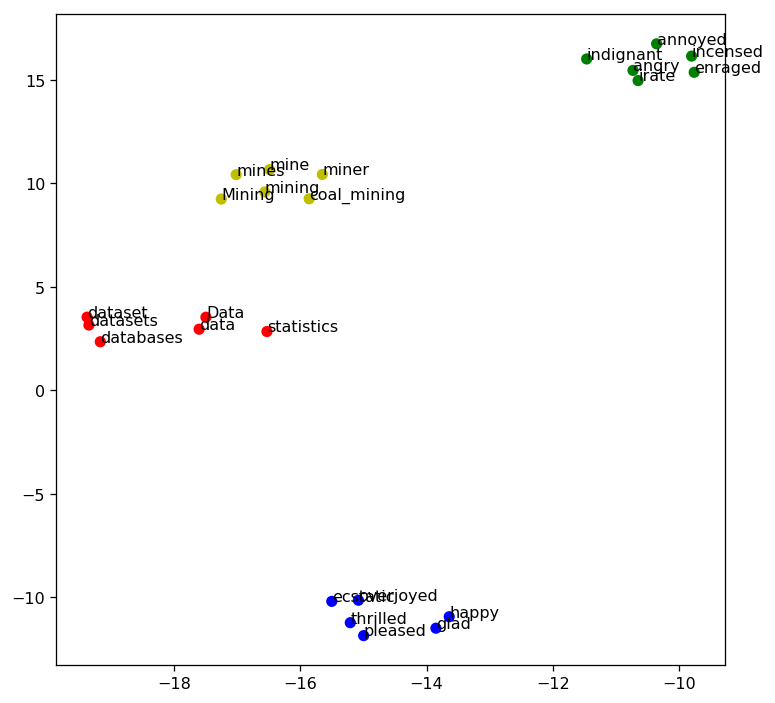

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.vocab.keys())
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

---
![Imgur](https://i.imgur.com/lXBIX1Y.png)

![Imgur](https://i.imgur.com/rDT04Ml.png)


---

---

![Imgur](https://i.imgur.com/MH3DkUq.png)

Assignment 2 competition link: [here](https://www.kaggle.com/c/datamininglab2)     
(you can not join by this link, we will announce the private link on iLMS)

### 1. Scoring

* Kaggle competition part **(40%)**:
![Imgur](https://i.imgur.com/EsMyKDS.png)   
    
   

* Competition report part **(60%)**:  
The score of your report will base on: readability, completeness, and creativity.

### 2. Important Dates

* 2018/11/05 (Mon) 12:30 p.m. - Start of competition


* 2018/11/25 (Sun) 23:00 p.m. - End of competition, final score announcement


* 2018/11/28 (Wed) 23:59 p.m. - Report submission (iLMS)

---

## Part 1: Kaggle competition

* Competition link will be announced on iLMS, only this course's student can involve, please don't share to others.   
  
  
* This is an indicidual competition, everyone is a team.    
  
  
* Before the end of the competition, you can only see the `Public Leaderboard` (Your score for public data).   
But your real score is decided by the private data, which is reveal on `Private Leaderboard` till the end of the competition.  
Try to avoid overfitting on public testing data.  
  
  
*  You are **not allowed** to use any pre-trained models or other datasets. But you can train any models from scratch by yourself.  
  
  
* You are **not allowed** to share your code to other classmate, but you could exchange your idea.  
  
  
* Other information are in our competition website.


---
## Part 2: Competition report

* Write and organize your report with jupyter notebook and upload it to iLMS.   
(The file name of your report must be `DM_hw2_{Your student ID}.ipynb`.  e.g DM_hw2_106065501.ipynb )
   
   
* In your report, you **need** to provide:
    * Your **student ID, name, team name, snapshot** of your `Private Leaderboard` score.  
    (Put these at the beginning of your report, or you will get **"0"**)   
         
    * code   
    (All the code which start from "load data" to "generate the file that submit to Kaggle") 
    
    * comments (short notes or explaination for your code)
    
   
* In your report, you **need** to include:
    * Descript whole flow/pipeline of your work  
      
    * How did you pre-process/clean your data
     
    * What feature engineering methods have you tried  
    
    * What model have you used
    
    * Did you encounter overfitting or underfitting problem? How did you against it
    
    * Conclusion
    

* In your report, it would be great to tell us:
    * Any special model and process method you tried during your experiments  
      
    * Share any interesting findings, feeling or suggestions   
      
    * compare different models and results   
    (store each experiment you have tried is a gooooog habit)

        
* Please, please, please....submit a "readable" jupyter notebook. (or we will deduct some score this time.)  
